In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import importlib
import helper_functions
importlib.reload(helper_functions)

from helper_functions import *

In [3]:
f = h5py.File('../data/Outfile_CellInformation_HOMDet.h5','r')

In [35]:
# for x in f.keys():
#     print(x)

## Cell Energy Distributions

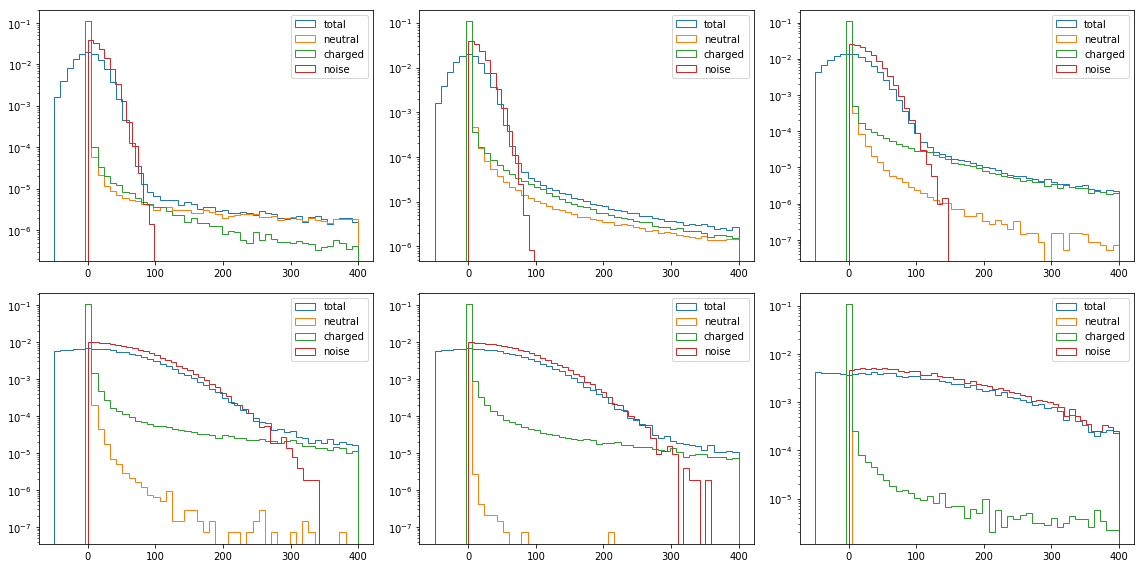

In [33]:
fig,ax = plt.subplots(2,3,figsize=(16,8))

for layer_i in range(6):
    
    ax_i = ax[int(layer_i /3)][int(layer_i % 3)]
    
    total_energy = f['RealRes_TotalEnergy_Layer'+str(layer_i+1)][:].flatten()
    
    charged_energy = f['RealRes_ChargedEnergy_Layer'+str(layer_i+1)][:].flatten()
    #charged_energy = charged_energy[charged_energy > 0]

    neutral_energy = f['RealRes_NeutralEnergy_Layer'+str(layer_i+1)][:].flatten()
    #neutral_energy = neutral_energy[neutral_energy > 0]

    noise =  f['RealRes_TotalEnergy_Layer'+str(layer_i+1)][:].flatten() \
                -f['RealRes_ChargedEnergy_Layer'+str(layer_i+1)][:].flatten() \
                    -f['RealRes_NeutralEnergy_Layer'+str(layer_i+1)][:].flatten()
    
    #noise = noise[noise > 0]
    
    ax_i.hist(total_energy,density=True,bins=np.linspace(-50,400,50),label='total',histtype='step')
    ax_i.hist(neutral_energy,density=True,bins=np.linspace(-50,400,50),label='neutral',histtype='step')
    ax_i.hist(charged_energy,density=True,bins=np.linspace(-50,400,50),label='charged',histtype='step')
    ax_i.hist(noise,density=True,histtype='step',bins=np.linspace(0,400,50),label='noise')
    ax_i.legend()
    ax_i.set_yscale('log')

plt.tight_layout()    
plt.show()

## cell neutral energy fraction distributions

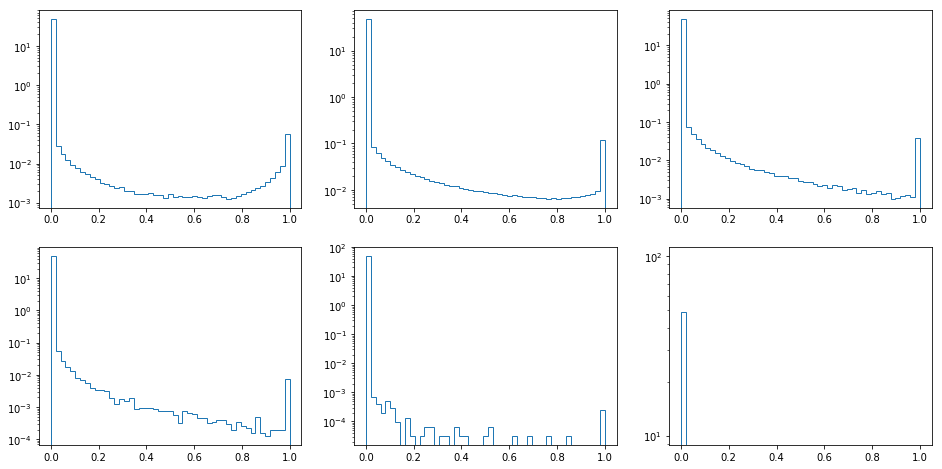

In [6]:
target_fractions = {}


for layer_i in range(6):
    total_energy = f['RealRes_TotalEnergy_Layer'+str(layer_i+1)][:].flatten()
    total_energy[total_energy < 0] = 0
    neutral_energy = f['RealRes_NeutralEnergy_Layer'+str(layer_i+1)][:].flatten()
    neutral_energy[neutral_energy > total_energy] = total_energy[neutral_energy > total_energy]
    target_fractions[layer_i+1] = np.zeros(len(neutral_energy))
    target_fractions[layer_i+1][total_energy > 0] = neutral_energy[total_energy > 0]/total_energy[total_energy > 0]

fig,ax = plt.subplots(2,3,figsize=(16,8))

for layer_i in range(6):
    
    ax_i = ax[int(layer_i /3)][int(layer_i % 3)]
    


    ax_i.hist(target_fractions[layer_i+1],density=True,bins=np.linspace(0,1,50),histtype='step')
    
    ax_i.set_yscale('log')
plt.show()

## cell neutral fraction as a function of cell energy

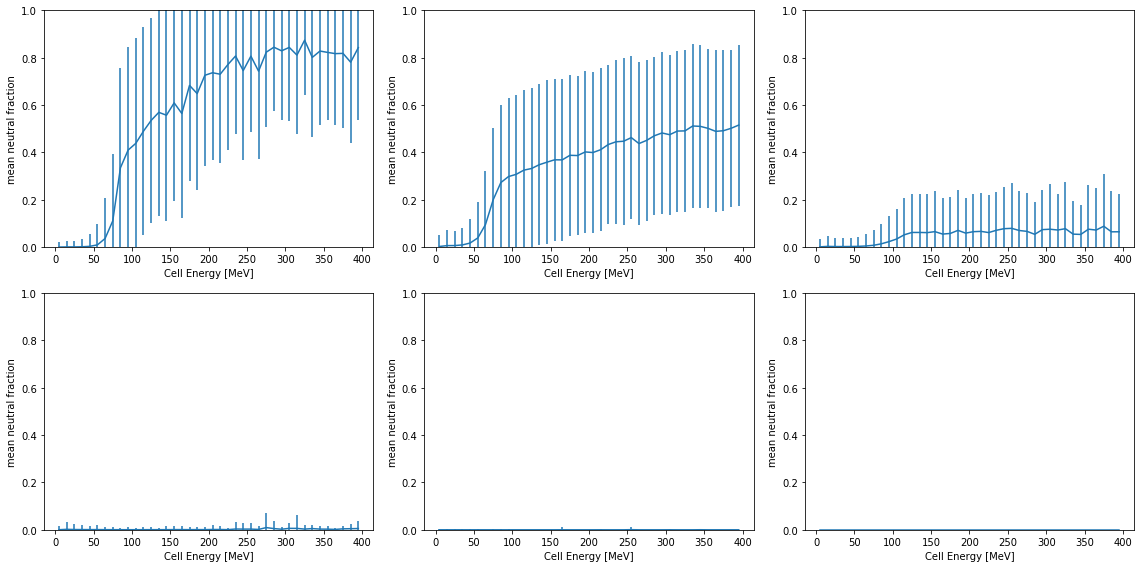

In [19]:
target_fractions = {}
cell_energies = {}

for layer_i in range(6):
    total_energy = f['RealRes_TotalEnergy_Layer'+str(layer_i+1)][:].flatten()
    total_energy[total_energy < 0] = 0
    
    cell_energies[layer_i+1] = total_energy
    
    neutral_energy = f['RealRes_NeutralEnergy_Layer'+str(layer_i+1)][:].flatten()
    neutral_energy[neutral_energy > total_energy] = total_energy[neutral_energy > total_energy]
    target_fractions[layer_i+1] = np.zeros(len(neutral_energy))
    target_fractions[layer_i+1][total_energy > 0] = neutral_energy[total_energy > 0]/total_energy[total_energy > 0]

fig,ax = plt.subplots(2,3,figsize=(16,8))


energy_bins = np.linspace(0,400,41)

for layer_i in range(6):
    
    ax_i = ax[int(layer_i /3)][int(layer_i % 3)]
    
    fractions = target_fractions[layer_i+1].copy()
    energies = cell_energies[layer_i+1].copy()
        
    frac_vs_energy = []
    for energy_bin in range(len(energy_bins)-1):
        low_val = energy_bins[energy_bin]
        high_val = energy_bins[energy_bin+1]
            
        selection = ((energies >= low_val) &(energies < high_val))
        
        mean_frac = np.mean(fractions[selection])
        std_frac = np.std(fractions[selection])
        centerval = (high_val+low_val)/2.0
        
        frac_vs_energy.append([centerval,mean_frac,std_frac])
        
        
    frac_vs_energy = np.array(frac_vs_energy)  
    
    ax_i.errorbar(frac_vs_energy[:,0],frac_vs_energy[:,1],yerr=frac_vs_energy[:,2])
    
    ax_i.set_ylim(0,1)
    ax_i.set_xlabel('Cell Energy [MeV]')
    ax_i.set_ylabel('mean neutral fraction')
plt.tight_layout()
plt.show()

# Event display

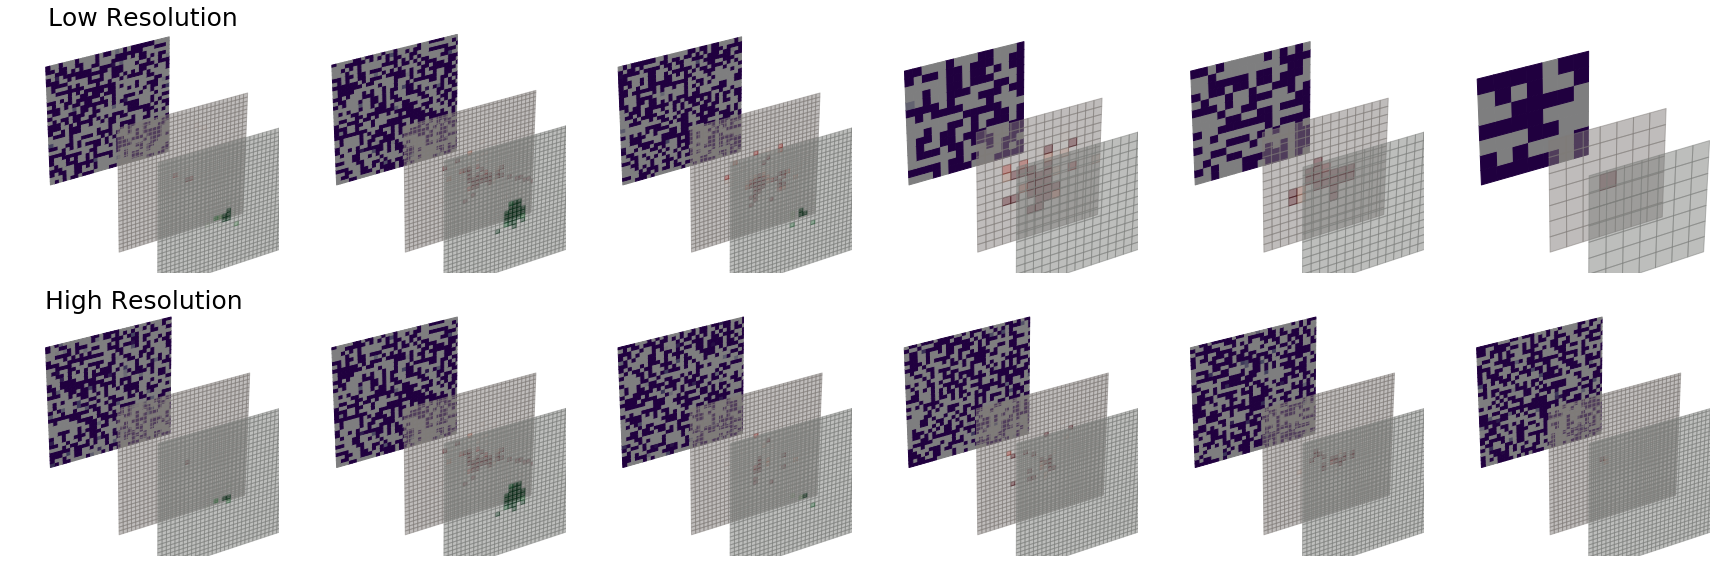

In [7]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt,numpy as np
norm = plt.Normalize()

event_index = 566

fig = plt.figure(figsize=(6*4,8))



ax_list = []
for layer_i in range(6):
    for res_i, res in enumerate(['RealRes','UniformRes']):
    
        ax_list.append( fig.add_subplot(2, 6, layer_i+1+6*res_i, projection='3d') ) 
        if layer_i+1+6*res_i == 1:
            ax_list[-1].set_title('Low Resolution',fontsize=25)
        elif layer_i+1+6*res_i == 7:
            ax_list[-1].set_title('High Resolution',fontsize=25)
        ax_list[-1].view_init(elev=30, azim=-30)

        X = f[res+'_TotalEnergy_Layer'+str(layer_i+1)][event_index]
        X_charged = f[res+'_ChargedEnergy_Layer'+str(layer_i+1)][event_index]
        X_neutral = f[res+'_NeutralEnergy_Layer'+str(layer_i+1)][event_index]
        
        layer_size = X.shape[1]
        X = X.reshape(layer_size,layer_size)
        X_charged = X_charged.reshape(layer_size,layer_size)
        X_neutral = X_neutral.reshape(layer_size,layer_size)
        
        small_x = 2.5*np.ones((layer_size,layer_size))
        
        Z, Y = np.meshgrid(range(layer_size),range(layer_size))
        
        ax_list[-1].plot_surface(0*small_x, Y, Z, 
                                facecolors=plt.cm.Purples(X))
        
        ax_list[-1].plot_surface(small_x*2, Y, Z, 
                                facecolors=plt.cm.Reds(X_charged),alpha=0.5)
        ax_list[-1].plot_surface(small_x*3, Y, Z, 
                                facecolors=plt.cm.Greens(X_neutral),alpha=0.5)
        
        ax_list[-1].set_xlabel('X')
        ax_list[-1].set_xlim(0,5)
        ax_list[-1].set_ylabel('Y')
        ax_list[-1].set_ylim(0, layer_size)
        ax_list[-1].set_zlabel('Z')
        ax_list[-1].set_zlim(0, layer_size)
        ax_list[-1].set_axis_off()
    
plt.tight_layout()    
plt.show()

## average images

work in progress

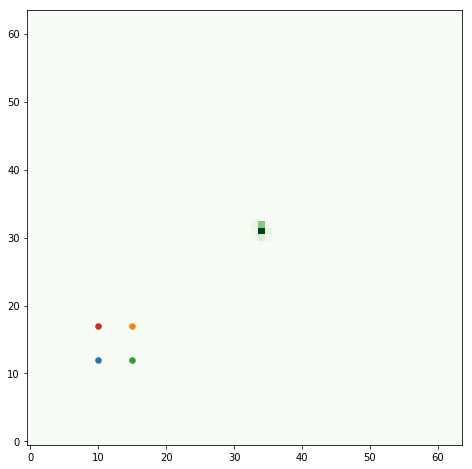

In [46]:
fig,ax = plt.subplots(figsize=(8,8))

event_index = 123

neutral_image = f['RealRes_NeutralEnergy_Layer2'][event_index]

img_size = neutral_image.shape[1]

neutral_image = neutral_image.reshape(img_size,img_size)

x_neutral,y_neutral = MakeTruthTrajectory(f['Pi0_Theta'][event_index],f['Pi0_Phi'][event_index],-5,-5)[0]
ax.scatter(x_neutral,y_neutral,s=30)

x_neutral,y_neutral = MakeTruthTrajectory(f['Pi0_Theta'][event_index],f['Pi0_Phi'][event_index],5,5)[0]
ax.scatter(x_neutral,y_neutral,s=30)

x_neutral,y_neutral = MakeTruthTrajectory(f['Pi0_Theta'][event_index],f['Pi0_Phi'][event_index],5,-5)[0]
ax.scatter(x_neutral,y_neutral,s=30)

x_neutral,y_neutral = MakeTruthTrajectory(f['Pi0_Theta'][event_index],f['Pi0_Phi'][event_index],-5,5)[0]
ax.scatter(x_neutral,y_neutral,s=30)

ax.imshow(neutral_image,cmap='Greens',origin='lower')
